In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from google.colab import files # Colab-specific library
import warnings
import io

warnings.filterwarnings('ignore')

# -----------------------------------------------------------------------
# 1. FILE UPLOADER DIALOG (Colab-specific)
# -----------------------------------------------------------------------
print("Please upload your Amazon stock CSV file using the dialog that appears.")
uploaded = files.upload()

# Assuming only one file was uploaded
if not uploaded:
    print("\nFile upload cancelled. Exiting preprocessing script.")
    exit()

# Get the filename and read the content
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')))

print(f"\nSuccessfully uploaded and loaded file: {filename}")
# -----------------------------------------------------------------------
# 2. DATA CLEANING AND PREPROCESSING (The core logic) ✨
# -----------------------------------------------------------------------

try:
    print("--- Initial Data Info ---")
    print(df.head())

    # Convert 'Date' to datetime and set it as the index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)

    # Drop duplicates and the 'Adj Close' column if present
    df.drop_duplicates(inplace=True)
    if 'Adj Close' in df.columns:
        df.drop('Adj Close', axis=1, inplace=True)

    # Convert to numeric and Handle Missing Values
    price_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in price_cols:
        # Convert columns to numeric, coercing any errors (like non-numeric text) to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Use linear interpolation for missing values in stock data
    df.interpolate(method='linear', axis=0, inplace=True)
    df.fillna(method='ffill', inplace=True) # Fallback for initial NaNs

    # -----------------------------------------------------------------------
    # 3. Feature Engineering (Technical Indicators) 📊
    # -----------------------------------------------------------------------

    short_window = 20  # Approx. one trading month
    medium_window = 50 # Approx. two trading months

    # A. Returns and Lagged Features
    df['Daily_Return'] = df['Close'].pct_change() * 100
    df['Lag_1_Close'] = df['Close'].shift(1) # Previous day's close price

    # B. Simple Moving Average (SMA) - Captures trend
    df['SMA_20'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_50'] = df['Close'].rolling(window=medium_window).mean()

    # C. Volatility - Captures market risk
    df['Volatility_20'] = df['Daily_Return'].rolling(window=short_window).std()

    # D. MACD - Captures momentum (difference between two EMAs)
    df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Drop rows that don't have enough data to calculate the rolling features
    df.dropna(inplace=True)

    # -----------------------------------------------------------------------
    # 4. Scaling and Final Split (for ML) 🔬
    # -----------------------------------------------------------------------

    features = [col for col in df.columns if col != 'Close']
    target = 'Close'

    X = df[features]
    y = df[target]

    # Scale the features (Min-Max scaling is ideal for deep learning models like LSTMs)
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

    # Time-series split (80% Train, 20% Test) - done chronologically
    train_size = int(len(X_scaled_df) * 0.8)

    X_train = X_scaled_df.iloc[:train_size].values
    y_train = y.iloc[:train_size].values

    X_test = X_scaled_df.iloc[train_size:].values
    y_test = y.iloc[train_size:].values

    print("---------------------------------------------------------")
    print("--- Final Preprocessing Complete ---")
    print(f"Total processed samples: {len(df)}")
    print(f"Features (X) for training: {X_train.shape}")
    print(f"Features (X) for testing:  {X_test.shape}")
    print("Data is ready for your machine learning model.")
    print("---------------------------------------------------------")

except Exception as e:
    print(f"\nAn unexpected error occurred during processing: {e}")

Please upload your Amazon stock CSV file using the dialog that appears.


Saving Amazon.csv to Amazon (1).csv

Successfully uploaded and loaded file: Amazon (1).csv
--- Initial Data Info ---
         Date      Open      High       Low     Close  Adj Close    Volume
0  1997-05-15  2.437500  2.500000  1.927083  1.958333   1.958333  72156000
1  1997-05-16  1.968750  1.979167  1.708333  1.729167   1.729167  14700000
2  1997-05-19  1.760417  1.770833  1.625000  1.708333   1.708333   6106800
3  1997-05-20  1.729167  1.750000  1.635417  1.635417   1.635417   5467200
4  1997-05-21  1.635417  1.645833  1.375000  1.427083   1.427083  18853200
---------------------------------------------------------
--- Final Preprocessing Complete ---
Total processed samples: 6106
Features (X) for training: (4884, 11)
Features (X) for testing:  (1222, 11)
Data is ready for your machine learning model.
---------------------------------------------------------



--- Corrected Data Alignment ---
Testing Features Shape (X_test_clf): (1222, 11)
Testing Target Shape (y_test_clf): (1222,)
--------------------------------------------------
Training Random Forest Classifier...
Training Complete.

          MODEL PERFORMANCE ON TEST DATA
Accuracy Score: 0.4558 (Overall Correct Predictions)

Classification Report (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

    Down (0)       0.45      0.98      0.62       548
      Up (1)       0.66      0.03      0.05       674

    accuracy                           0.46      1222
   macro avg       0.55      0.50      0.34      1222
weighted avg       0.56      0.46      0.31      1222



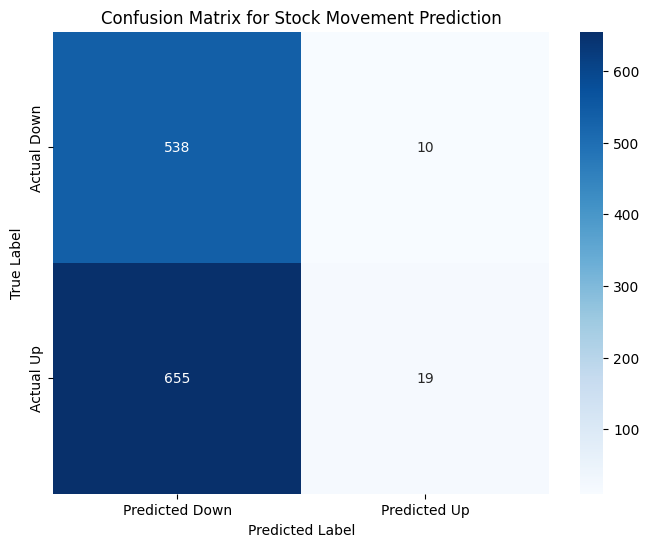


            TOP 5 FEATURE IMPORTANCES
Daily_Return     0.112324
Volume           0.110062
Volatility_20    0.104765
MACD             0.095931
MACD_Signal      0.095633


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# --- ASSUMPTION: 'df' is the final pre-processed DataFrame from your previous cell. ---

# -----------------------------------------------------------------------
# 1. RE-ALIGN AND CREATE CLASSIFICATION TARGET (Necessary for consistent length) 🎯
# -----------------------------------------------------------------------

# Create the binary target: 1 if next day's Close > current Close, 0 otherwise
df['Target_Movement'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df_clf = df.dropna()

# Define features (X) and the classification target (y)
features = [col for col in df_clf.columns if col not in ['Close', 'Target_Movement']]
X_all_clf = df_clf[features].values
y_all_clf = df_clf['Target_Movement'].values

# Scale ALL features (this ensures consistency)
scaler = MinMaxScaler(feature_range=(0, 1))
X_all_scaled_clf = scaler.fit_transform(X_all_clf)

# Time-series split (80% Train, 20% Test)
train_size_clf = int(len(df_clf) * 0.8)

# Assign final, CORRECTLY ALIGNED arrays
X_train_clf = X_all_scaled_clf[:train_size_clf]
X_test_clf = X_all_scaled_clf[train_size_clf:]
y_train_clf = y_all_clf[:train_size_clf]
y_test_clf = y_all_clf[train_size_clf:]

print("\n--- Corrected Data Alignment ---")
print(f"Testing Features Shape (X_test_clf): {X_test_clf.shape}")
print(f"Testing Target Shape (y_test_clf): {y_test_clf.shape}")
print("-" * 50)


# -----------------------------------------------------------------------
# 2. RANDOM FOREST MODEL TRAINING AND EVALUATION 🌲
# -----------------------------------------------------------------------

rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=15, random_state=42, class_weight='balanced'
)

print("Training Random Forest Classifier...")
rf_model.fit(X_train_clf, y_train_clf)
print("Training Complete.")

# Make predictions on the test set
y_pred_clf = rf_model.predict(X_test_clf)

print("\n" + "="*50)
print("          MODEL PERFORMANCE ON TEST DATA")
print("="*50)

# Accuracy Score
accuracy = accuracy_score(y_test_clf, y_pred_clf)
print(f"Accuracy Score: {accuracy:.4f} (Overall Correct Predictions)")

# Classification Report
print("\nClassification Report (Precision, Recall, F1-Score):")
print(classification_report(y_test_clf, y_pred_clf, target_names=['Down (0)', 'Up (1)']))


# -----------------------------------------------------------------------
# 3. CONFUSION MATRIX VISUALIZATION 🖼️
# -----------------------------------------------------------------------

cm = confusion_matrix(y_test_clf, y_pred_clf)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted Down', 'Predicted Up'],
    yticklabels=['Actual Down', 'Actual Up']
)
plt.title('Confusion Matrix for Stock Movement Prediction')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
#

# -----------------------------------------------------------------------
# 4. FEATURE IMPORTANCE
# -----------------------------------------------------------------------

feature_names_aligned = features
feature_importances = pd.Series(rf_model.feature_importances_, index=feature_names_aligned)
feature_importances = feature_importances.sort_values(ascending=False)

print("\n" + "="*50)
print("            TOP 5 FEATURE IMPORTANCES")
print("="*50)
print(feature_importances.head(5).to_string())